In [5]:
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names and filter out non-directory files
    folds = [fold for fold in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, fold))]

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    return df

# change label names to its original names
def change_label_names(df, column_name):
    index = {
        'lung_aca': 'Lung_adenocarcinoma', 
        'lung_n': 'Lung_benign_tissue', 
        'lung_scc': 'Lung_squamous_cell_carcinoma',
        'colon_aca': 'Colon_adenocarcinoma',
        'colon_n': 'Colon_benign_tissue'
    }
    df[column_name] = df[column_name].replace(index)

# Updated address for both lung and colon datasets
data_dirs = [
    "/Users/harikiranvg/Downloads/lung_colon_image_set/lung_image_sets",
    "/Users/harikiranvg/Downloads/lung_colon_image_set/colon_image_sets"
]

# Load and merge data from both datasets
dataframes = [loading_the_data(data_dir) for data_dir in data_dirs]
df = pd.concat(dataframes, ignore_index=True)

change_label_names(df, 'labels')

df


filepaths                labels
0      /Users/harikiranvg/Downloads/lung_colon_image_...   Lung_adenocarcinoma
1      /Users/harikiranvg/Downloads/lung_colon_image_...   Lung_adenocarcinoma
2      /Users/harikiranvg/Downloads/lung_colon_image_...   Lung_adenocarcinoma
3      /Users/harikiranvg/Downloads/lung_colon_image_...   Lung_adenocarcinoma
4      /Users/harikiranvg/Downloads/lung_colon_image_...   Lung_adenocarcinoma
...                                                  ...                   ...
24995  /Users/harikiranvg/Downloads/lung_colon_image_...  Colon_adenocarcinoma
24996  /Users/harikiranvg/Downloads/lung_colon_image_...  Colon_adenocarcinoma
24997  /Users/harikiranvg/Downloads/lung_colon_image_...  Colon_adenocarcinoma
24998  /Users/harikiranvg/Downloads/lung_colon_image_...  Colon_adenocarcinoma
24999  /Users/harikiranvg/Downloads/lung_colon_image_...  Colon_adenocarcinoma

[25000 rows x 2 columns]

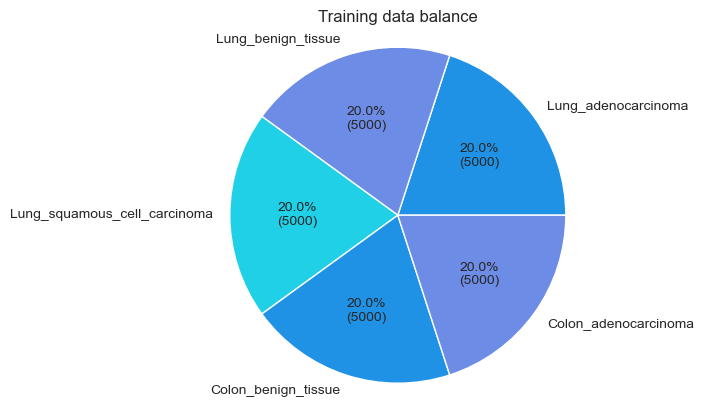

In [6]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [7]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [8]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


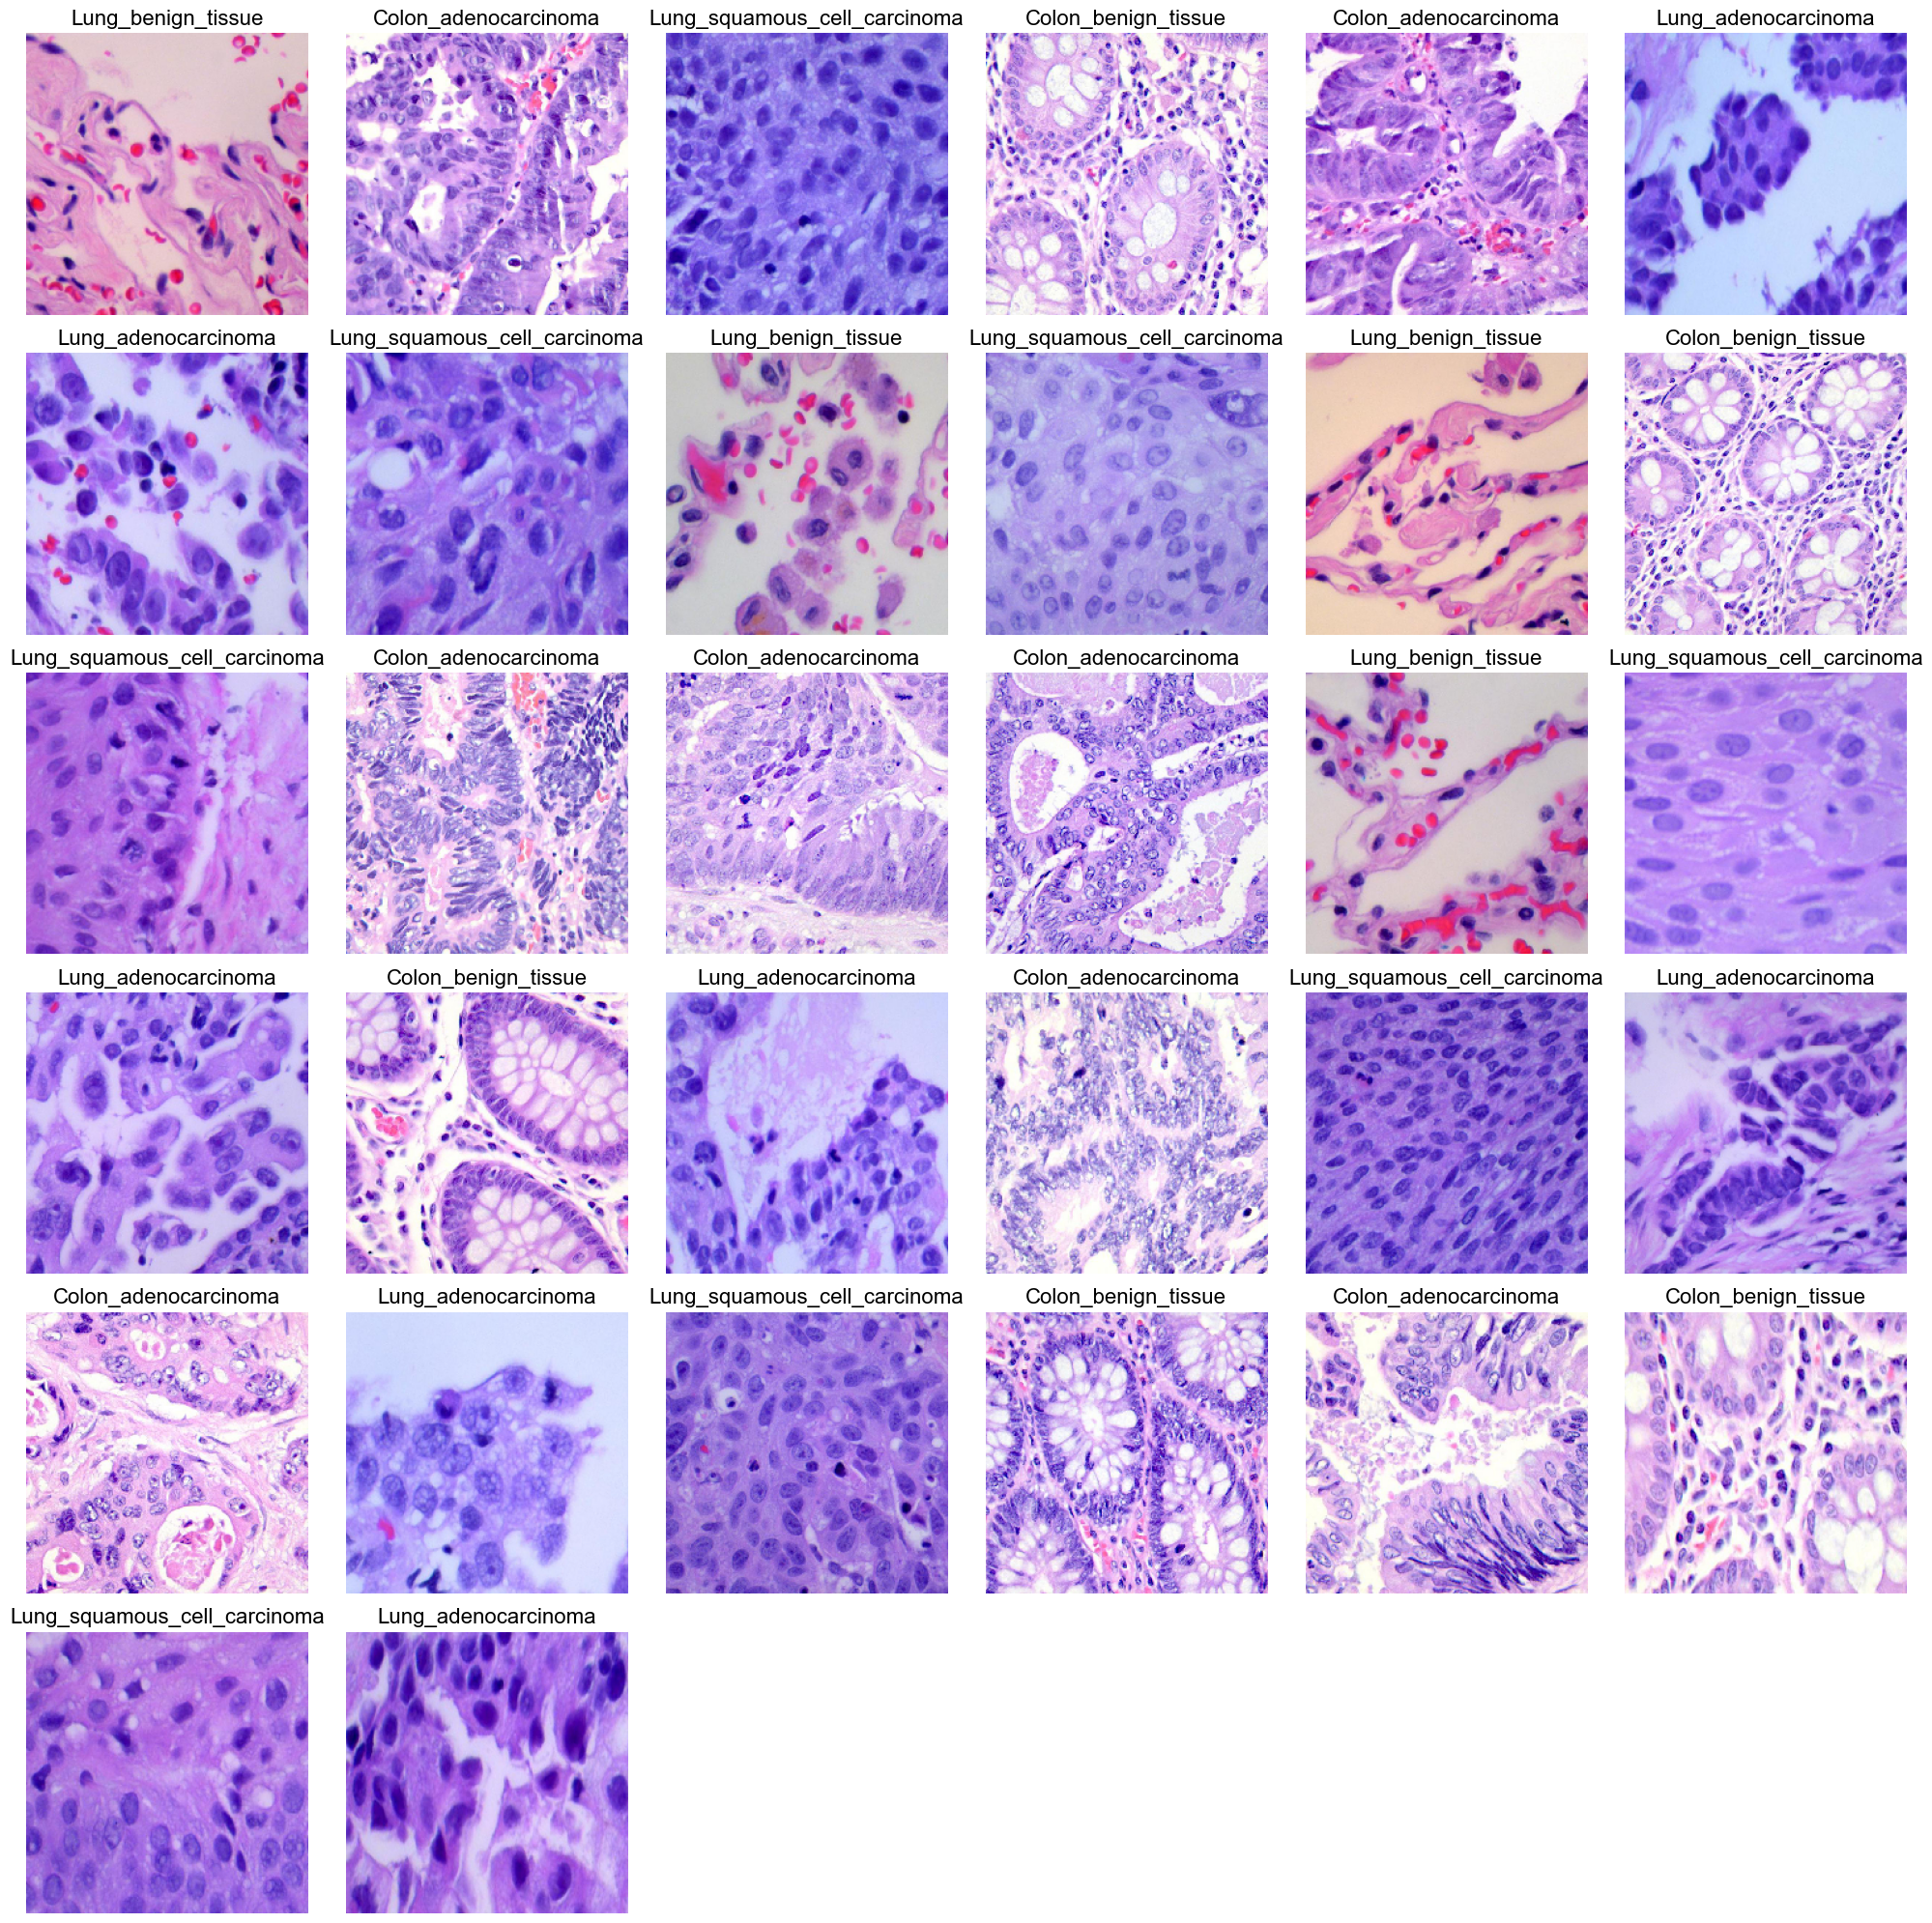

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    
    
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [11]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [12]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))


In [13]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 56, 56, 32)        14016     
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 64)        55680     
                                                                 
 sequential_3 (Sequential)   (None, 14, 14, 128)       2

In [14]:
# train the model
epochs = 5  # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/5
625/625 [==============================] - 472s 753ms/step - loss: 0.6069 - accuracy: 0.7746 - val_loss: 0.4028 - val_accuracy: 0.8552
Epoch 2/5
625/625 [==============================] - 552s 884ms/step - loss: 0.2510 - accuracy: 0.9176 - val_loss: 0.1284 - val_accuracy: 0.9524
Epoch 3/5
625/625 [==============================] - 521s 833ms/step - loss: 0.1847 - accuracy: 0.9388 - val_loss: 0.5428 - val_accuracy: 0.8440
Epoch 4/5
625/625 [==============================] - 505s 808ms/step - loss: 0.1521 - accuracy: 0.9493 - val_loss: 0.2697 - val_accuracy: 0.9088
Epoch 5/5
625/625 [==============================] - 526s 841ms/step - loss: 0.1297 - accuracy: 0.9582 - val_loss: 0.1257 - val_accuracy: 0.9548


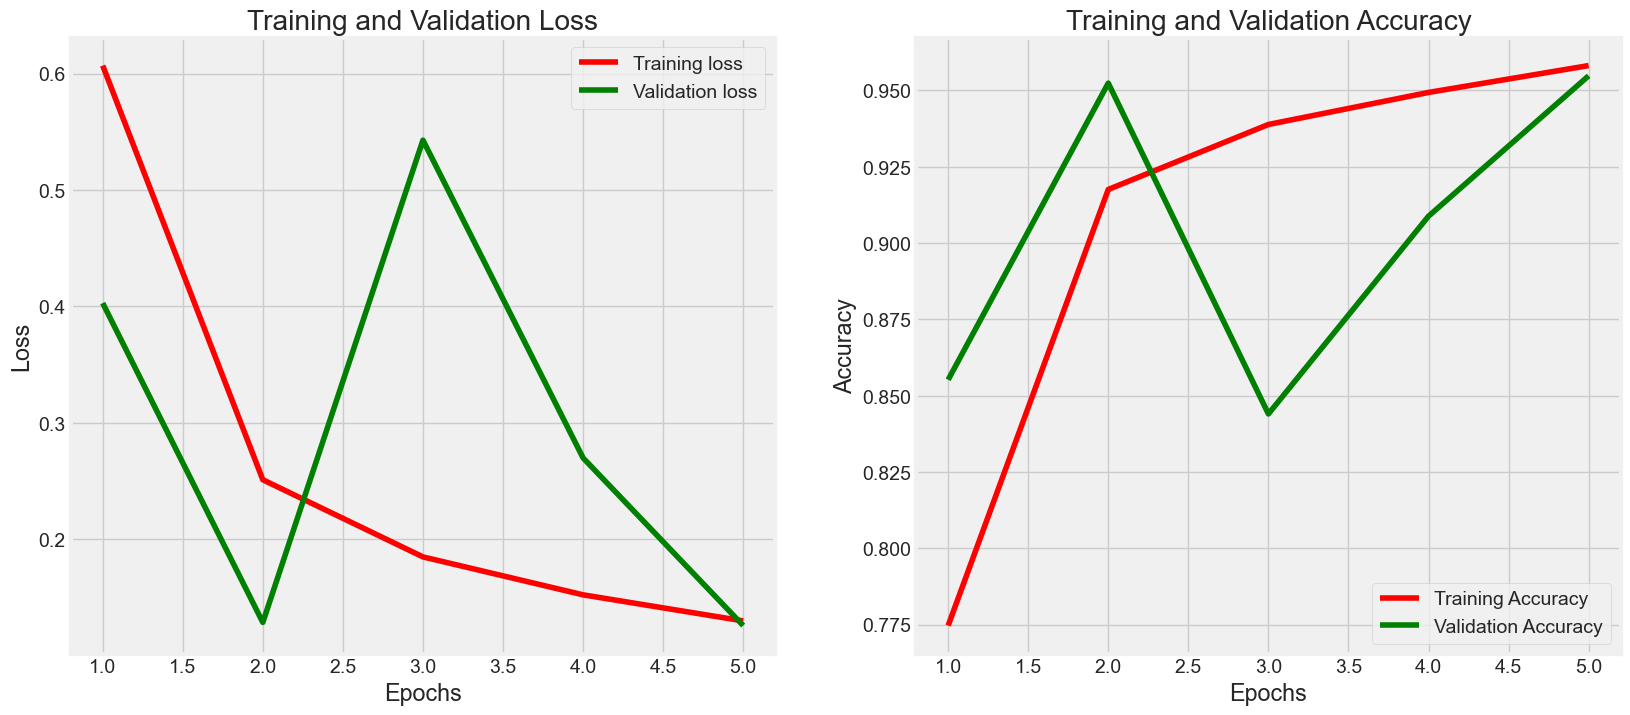

In [15]:
# Display model performance
model_performance(history, epochs)

In [16]:
# Model evaluation
model_evaluation(cnn_model)

79/79 [==============================] - 21s 270ms/step - loss: 0.1142 - accuracy: 0.9544
Train Loss:  0.10290633887052536
Train Accuracy:  0.9596499800682068
--------------------
Validation Loss:  0.12565337121486664
Validation Accuracy:  0.954800009727478
--------------------
Test Loss:  0.1142134740948677
Test Accuracy:  0.9544000029563904


79/79 [==============================] - 16s 200ms/step


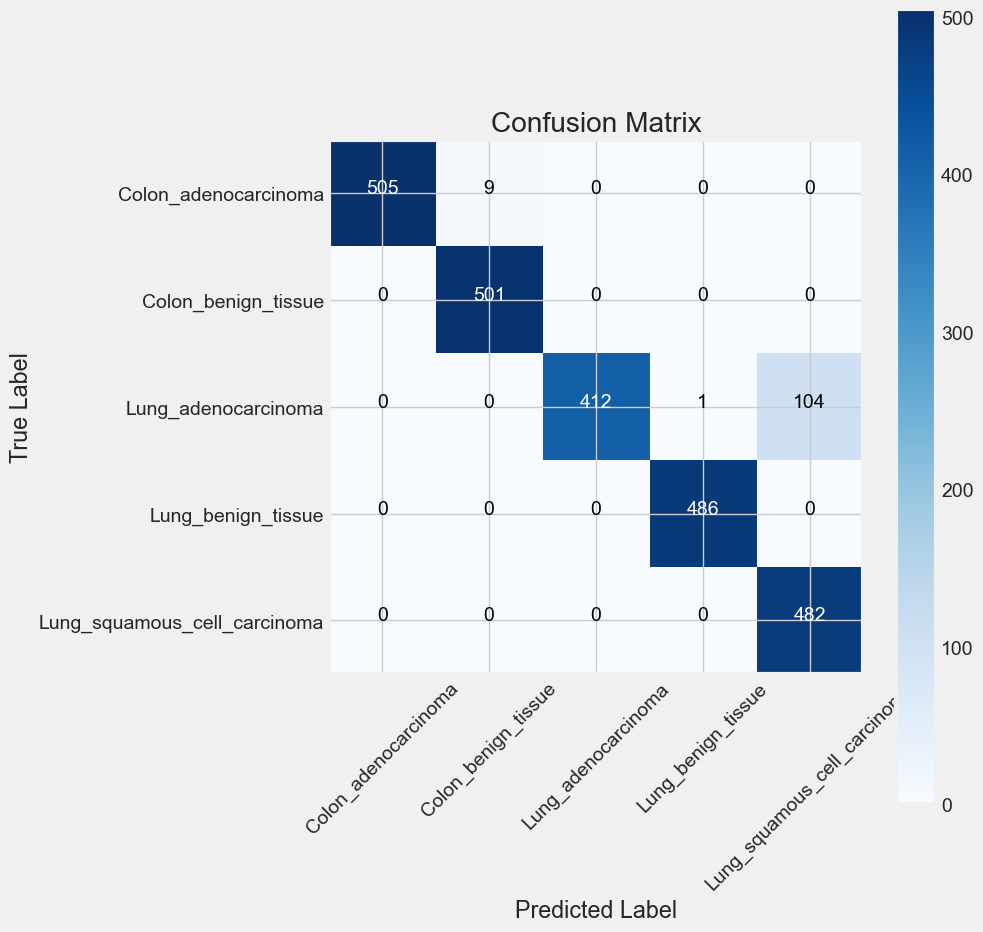

In [17]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)